In [1]:
import psycopg2
from dotenv import load_dotenv
import os

from transformers import BertModel, BertTokenizer

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

from tqdm import tqdm

c:\Users\bchen\anaconda3\envs\cs439\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Connecting to Supabase + Loading Data

In [2]:
# Load environment variables from .env
load_dotenv()

# Fetch variables
USER = os.getenv("user")
PASSWORD = os.getenv("password")
HOST = os.getenv("host")
PORT = os.getenv("port")
DBNAME = os.getenv("dbname")

# Connect to the database
try:
    connection = psycopg2.connect(
        user=USER,
        password=PASSWORD,
        host=HOST,
        port=PORT,
        dbname=DBNAME
    )
    print("Connection successful!")

except Exception as e:
    print(f"Failed to connect: {e}")

Connection successful!


In [3]:
query = "SELECT post_id, combined, label FROM aita_posts LIMIT 500;"
df = pd.read_sql_query(query, connection)

df.head()

C:\Users\bchen\AppData\Local\Temp\ipykernel_27784\1279328471.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, connection)


,post_id,combined,label
0,1k6igkk,aita freak mom watch brother 14f 13 m brother ...,Not the A-hole
1,1k6hyib,aita ask brother m19 voice chat friend night f...,Not the A-hole
2,1k6gmp6,aita let bf use desk chair 34nb bf(35 m live 9...,Not the A-hole
3,1k6g0wj,aita tell wife quit smoking asshole tell wife ...,Not the A-hole
4,1k6flrt,aita share switch 14f young sister 12f switch ...,Not the A-hole


Check for class imbalance

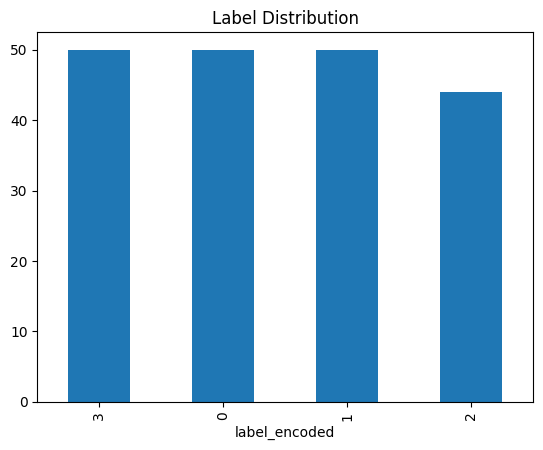

In [15]:
import matplotlib.pyplot as plt

df['label_encoded'].value_counts().plot(kind='bar')
plt.title("Label Distribution")
plt.show()

## Testing BERT

Set up HuggingFace BERT model and load pre-trained weights

In [9]:
model = BertModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

BERT tokenizer for preprocessing

In [10]:
sample_text = "Reddit posts can sometimes go viral overnight."

# Tokenize input text
inputs = tokenizer(
    sample_text,
    padding='max_length',
    truncation=True,
    max_length=128,
    return_tensors='pt'  # PyTorch tensors
)

print(inputs.keys())  # Input IDs and attention mask

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])


## BERT Classifier

Define model class

In [16]:
class BERTClassifier(nn.Module):
    def __init__(self, dropout=0.3):
        super(BERTClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(self.bert.config.hidden_size, 4)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = outputs.last_hidden_state
        pooled_output = last_hidden_state.mean(dim=1)
        x = self.dropout(pooled_output)

        return self.classifier(x)
    
    def train_model(self, train_loader, optimizer, loss_fn, device, epochs=3):
        self.train()
        for epoch in range(epochs): 
            loop = tqdm(train_loader, leave=True)
            for batch in loop:
                optimizer.zero_grad()

                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)

                outputs = self(input_ids, attention_mask)
                loss = loss_fn(outputs, labels)
                loss.backward()
                optimizer.step()

                loop.set_description(f'Epoch {epoch}')
                loop.set_postfix(loss=loss.item())

    def evaluate_model(self, test_loader, device):
        self.eval()
        predictions, true_labels = [], []

        with torch.no_grad():
            for batch in test_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)

                outputs = self(input_ids, attention_mask)
                preds = torch.argmax(outputs, axis=1)

                predictions.extend(preds.cpu().numpy())
                true_labels.extend(labels.cpu().numpy())

        # Metrics
        acc = accuracy_score(true_labels, predictions)
        f1 = f1_score(true_labels, predictions, average='weighted')

        print(f'Accuracy: {acc:.4f}')
        print(f'F1-Score: {f1:.4f}')

        return predictions, true_labels, acc, f1

Encode labels

In [5]:
label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['label'])
print(label_encoder.classes_)  # View label mappings

['Asshole' 'Everyone Sucks' 'No A-holes here' 'Not the A-hole']


Train-Test Split

In [6]:
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['combined'].values, 
    df['label_encoded'].values, 
    test_size=0.2, 
    random_state=42
)

Tokenize text

In [7]:
# Tokenize
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_encodings = tokenizer(list(train_texts), truncation=True, padding=True, max_length=128, return_tensors='pt')
test_encodings = tokenizer(list(test_texts), truncation=True, padding=True, max_length=128, return_tensors='pt')

# Convert labels to tensors
train_labels = torch.tensor(train_labels)
test_labels = torch.tensor(test_labels)

Dataset class

In [9]:
class RedditDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

train_dataset = RedditDataset(train_encodings, train_labels)
test_dataset = RedditDataset(test_encodings, test_labels)

Setup train and test loaders, and other things

In [17]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = BERTClassifier()
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
loss_fn = nn.CrossEntropyLoss()

Training

In [18]:
model.train_model(train_loader, optimizer, loss_fn, device, epochs=8)

Epoch 7: 100%|██████████| 10/10 [02:06<00:00, 12.62s/it, loss=0.558]


In [20]:
predictions, true_labels, acc, f1 = model.evaluate_model(test_loader, device)

Accuracy: 0.2564
F1-Score: 0.2141
